### 自动求梯度

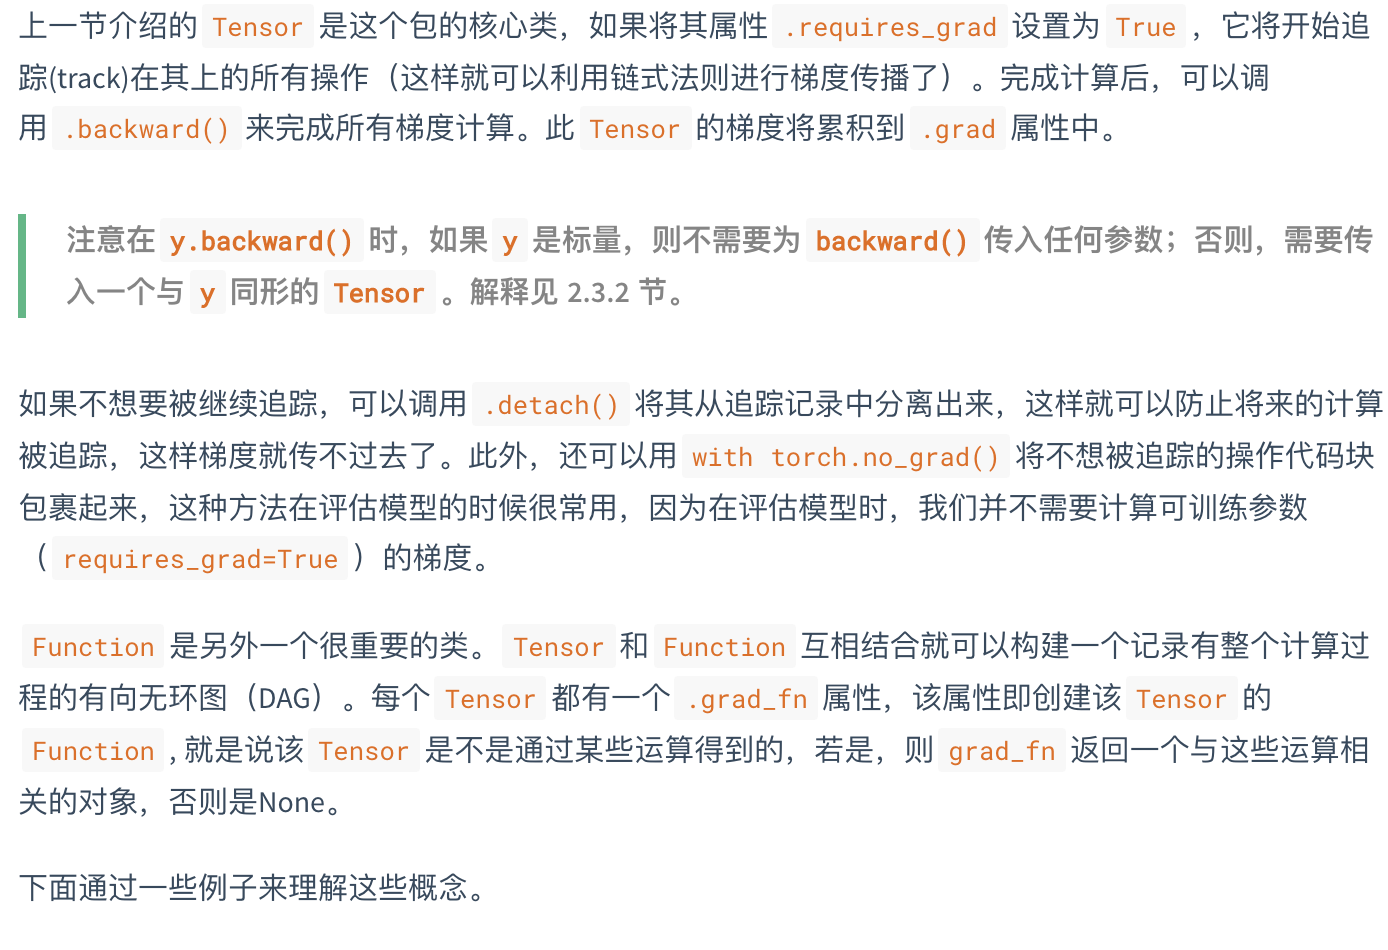

In [7]:
import torch
#x是直接创建的，所以它没有grad_fn，而y是通过一个加法操作创建的，所以它有grad_fn
#像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None
x=torch.ones(2,2,requires_grad=True)
print(x)
print(x.grad_fn)

y=x+2
print(y)
print(y.grad_fn)

#复杂一点的运算
z=y*y*3
out=z.mean()
print(z,out)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [8]:
#通过.requires_grad_()来用in-place的方式改变requires_grad属性

a=torch.randn(2,2)#缺少情况下默认requires_grad=False
a=((a*3)/(a-1))
print(a.requires_grad) #False
a.requires_grad_(True)
print(a.requires_grad) #True
b=(a*a).sum()
print(b.grad_fn)

False
True


### 梯度

**注意：grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。**

**在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor**

**我们不允许张量对张量求导，只允许标量对张量求导，求导结果是和自变量同形的张量。所以必要时我们要把张量通过将所有张量的元素加权求和的方式转换为标量**，举个例子，假设y由自变量x计算而来，w是和y同形的张量，则y.backward(w)的含义是：先计算l = torch.sum(y * w)，则l是个标量，然后求l对自变量x的导数。

使用with torch.no_grad()来中断梯度跟踪。

有时候，我们想要修改tensor的数值，但是又不希望被autograd记录(即不会影响反向传播),那么我们可以对tensor.data进行操作。

In [11]:
import torch
#x是直接创建的，所以它没有grad_fn，而y是通过一个加法操作创建的，所以它有grad_fn
#像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None
x=torch.ones(2,2,requires_grad=True)
y=x+2

#复杂一点的运算
z=y*y*3
out=z.mean()

out.backward()
print(x.grad)

#grad在反向传播过程中是累加的，这意味着每次运行一次反向传播，梯度都会累加之前的梯度
#所以一般在反向传播之前需要把梯度清零
out2=x.sum()
out2.backward()
print(x.grad)

out3=x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


In [15]:
import torch

x=torch.tensor([1.0,2.0,3.0,4.0],requires_grad=True)
y=2*x
#z不是标量，y是标量
z=y.view(2,2)
print(z)

#现在z不是一个标量，所以在调用backward时需要传入一个和z同形的权重向量进行加权求和得到一个标量
v=torch.tensor([[1.0,0.1],[0.01,0.001]],dtype=torch.float)
z.backward(v)
#x.grad是与x同形的张量
print(x.grad) 

tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)
tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [18]:
import torch
#中断梯度跟踪
x=torch.tensor(1.0,requires_grad=True)
y1=x**2
with torch.no_grad():
    y2=x**3
y3=y1+y2
print(x.requires_grad)
#y2是没有grad_fn的
print(y1,y1.requires_grad)
print(y2,y2.requires_grad)
print(y3,y3.requires_grad)
#由于中断了y2的梯度跟踪，所以相当于对y3=x^2求导
#不能调用y2.backward()会报错，因为y2.requreis_grad=False
y3.backward()
print(x.grad)

True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True
tensor(2.)


In [19]:
import torch
#修改tensor的数值，但是又不希望被autograd记录（即不会影响反向传播）
x=torch.ones(1,requires_grad=True)
#我们可以对tensor.data进行操作
print(x.data)
print(x.data.requires_grad) #False x.data已经是独立于计算图之外

y=2*x
x.data*=100

y.backward()
print(x)
print(x.grad)

tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])
